In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-09-29 11:37:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-09-29 11:37:31 (110 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [2]:
import json
with open('/tmp/sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []
for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [3]:
training_size = 20000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [4]:
vocab_size = 10000
oov_tok = "<OOV>"
padding_type="post"
max_length = 100
trunc_type = "post"
embedding_dim = 16 

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating="post")

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating="post")

In [6]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
import tensorflow as tf

model = tf.keras.Sequential([
                                   tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                                   tf.keras.layers.GlobalAveragePooling1D(),
                                   tf.keras.layers.Dense(24, activation = 'relu'),
                                   tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6649 - accuracy: 0.5809 - val_loss: 0.5784 - val_accuracy: 0.7098
Epoch 2/30
625/625 - 2s - loss: 0.4303 - accuracy: 0.8284 - val_loss: 0.3836 - val_accuracy: 0.8423
Epoch 3/30
625/625 - 2s - loss: 0.3098 - accuracy: 0.8794 - val_loss: 0.3530 - val_accuracy: 0.8530
Epoch 4/30
625/625 - 2s - loss: 0.2563 - accuracy: 0.8989 - val_loss: 0.3442 - val_accuracy: 0.8556
Epoch 5/30
625/625 - 2s - loss: 0.2211 - accuracy: 0.9147 - val_loss: 0.3502 - val_accuracy: 0.8538
Epoch 6/30
625/625 - 2s - loss: 0.1949 - accuracy: 0.9255 - val_loss: 0.3576 - val_accuracy: 0.8518
Epoch 7/30
625/625 - 2s - loss: 0.1719 - accuracy: 0.9354 - val_loss: 0.3649 - val_accuracy: 0.8536
Epoch 8/30
625/625 - 2s - loss: 0.1537 - accuracy: 0.9444 - val_loss: 0.4150 - val_accuracy: 0.8372
Epoch 9/30
625/625 - 2s - loss: 0.1401 - accuracy: 0.9482 - val_loss: 0.3988 - val_accuracy: 0.8504
Epoch 10/30
625/625 - 2s - loss: 0.1267 - accuracy: 0.9563 - val_loss: 0.4191 - val_accuracy: 0.8484

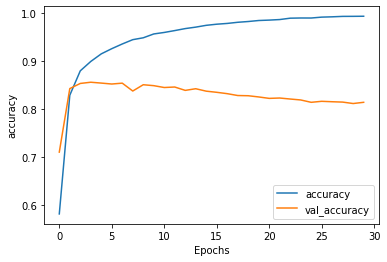

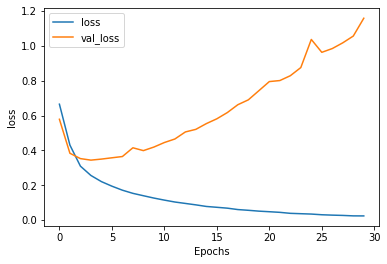

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

import io

out_v = io.open('vecs_sarcasm.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_sarcasm.tsv', 'w', encoding='utf-8')
for word_num in range(1,vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write("\t".join([str(val) for val in embeddings]) + "\n")
out_v.close()
out_m.close()

In [13]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs_sarcasm.tsv')
  files.download('meta_sarcasm.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>